# Multi-agent supervisor(구글 worksheet 연결해 보자)

The [previous example](../multi-agent-collaboration) routed messages automatically based on the output of the initial researcher agent.

We can also choose to use an [LLM to orchestrate](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) the different agents.

Below, we will create an agent group, with an agent supervisor to help delegate tasks.

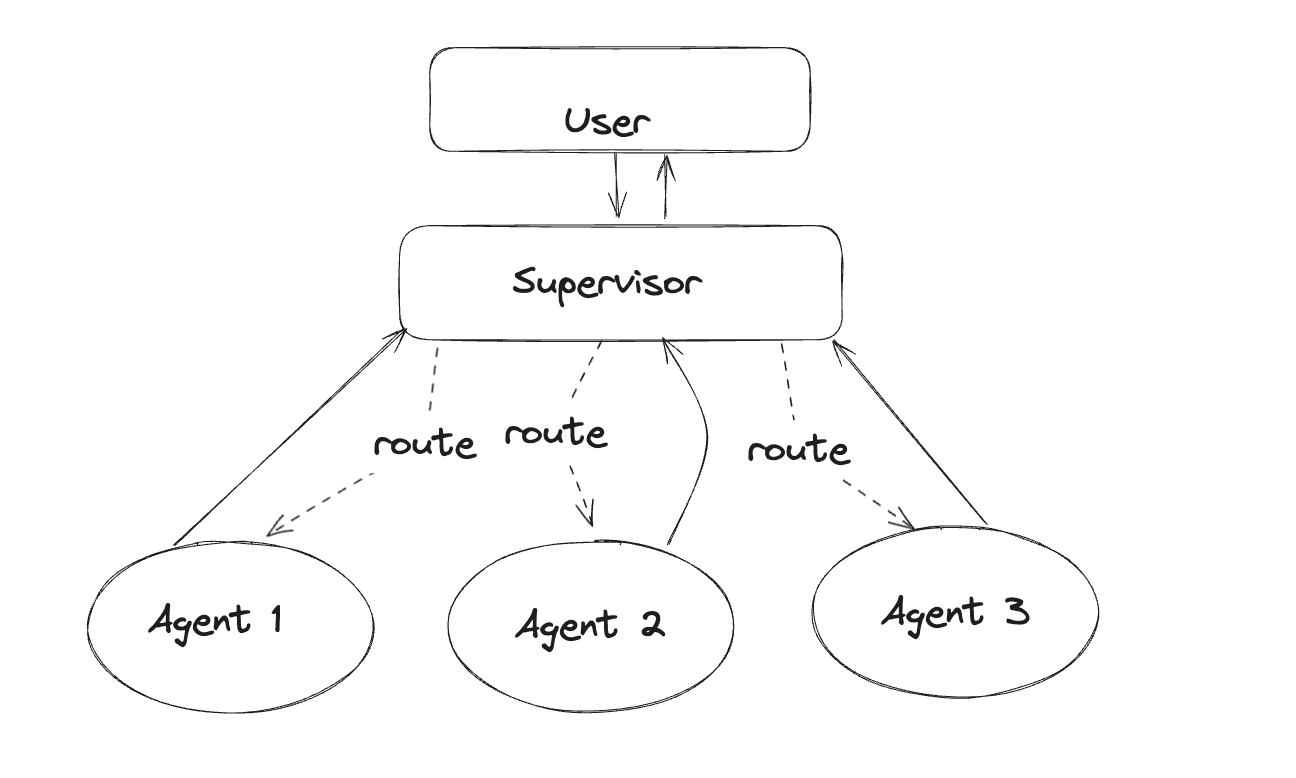

To simplify the code in each agent node, we will use LangGraph's prebuilt [create_react_agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent). This and other "advanced agent" notebooks are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

## Setup

First, let's install required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai langchain_experimental langsmith pandas

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [ ]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


os.environ["TAVILY_API_KEY"] = ""
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Create tools

For this example, you will make an agent to do web research with a search engine, and one agent to create plots. Define the tools they'll use below:

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

## Helper Utilities

Define a helper function that we will use to create the nodes in the graph - it takes care of converting the agent response to a human message. This is important because that is how we will add it the global state of the graph

In [4]:
from langchain_core.messages import HumanMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

### Create Agent Supervisor

It will use function calling to choose the next worker node OR finish processing.

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Coder", "SheetAnalyst"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
    "[IMPORTANT] For user queries asking for paths or times, call the SheetAnalyst worker first."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal[*options]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o")


def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

## Construct Graph

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

In [ ]:
# 구글 sheet 데이터 로딩 코드

import pandas as pd
import gspread
from typing import Any

json_file_path = "drive-sheet-01.json"


def googleSpreadData(url: str) -> Any:
    if url is None:
        return None

    gc = gspread.service_account(filename=json_file_path)
    # url = url

    ## 4. PythonSheet url을 바탕으로 스프레드 시트를 열고,
    doc = gc.open_by_url(url)

    workDf = pd.DataFrame()
    # print(doc.worksheets()[0].title)
    for sheet in doc.worksheets():
        print(sheet.title)
        data = doc.worksheet(sheet.title).get_all_values()
        df = pd.DataFrame(data[1:], columns=data[0])
        df["name"] = sheet.title
        workDf = pd.concat([workDf, df], ignore_index=True)
    # print(workDf)

    return workDf

In [ ]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI

url = "https://docs.google.com/spreadsheets/d/1rW-nTz7P69BHGCtp0amownjnuc2OJmFzJrQFoAfeKnc"
df = googleSpreadData(url)

퍼머넌트


In [8]:
import functools
import operator
from typing import Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

In [ ]:
sheet_agent = create_pandas_dataframe_agent(
    ChatOpenAI(model="gpt-4o", temperature=0),
    df,
    verbose=False,
    agent_type="tool-calling",
    allow_dangerous_code=True,
    prefix="You are a professional data analyst and expert in Pandas. "
    "You must use Pandas DataFrame(`df`) to answer user's request. "
    "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
    "If you are willing to generate visualization code, please use `plt.show()` at the end of your code. "
    "I prefer seaborn code for visualization, but you can use matplotlib as well.",
)


def sheet_node(state):
    # or whichever message in the state you need
    result = sheet_agent.invoke(state["messages"][-1].content)
    return {"messages": [HumanMessage(content=result["output"], name="SheetAnalyst")]}


# 이걸로 하면 input오류남!!!
# sheet_node = functools.partial(agent_node, agent=sheet_agent, name="SheetAnalyst")

In [10]:
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("SheetAnalyst", sheet_node)
workflow.add_node("supervisor", supervisor_agent)

Now connect all the edges in the graph.

In [11]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

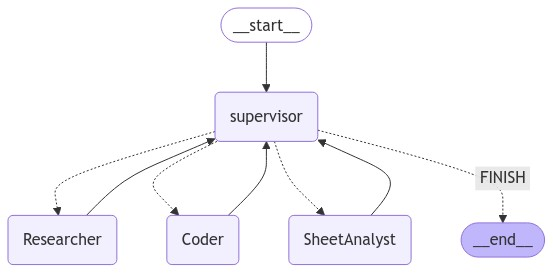

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke the team

With the graph created, we can now invoke it and see how it performs!

In [13]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content="The code `print('Hello, World!')` outputs:\n\n```\nHello, World!\n```", additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [ ]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="가장 짧은 거리의 코스명과 거리, 출발지점, 종료지점을 알려줘."
            )
        ]
    },
    {"recursion_limit": 5},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'SheetAnalyst'}}
----
{'SheetAnalyst': {'messages': [HumanMessage(content='가장 짧은 거리의 코스명은 "모래시계"이며, 거리는 200km입니다. 출발지점과 종료지점은 모두 "서울 반포"입니다.', additional_kwargs={}, response_metadata={}, name='SheetAnalyst')]}}
----
{'supervisor': {'next': 'FINISH'}}
----
